## ВКР: анализ данных

Автоматизация подбора персонала

Копчев Владислав, БПМИ197

В данном ноутбуке предобработанные в ноутбуке `preprocessing.ipynb` данные мы будем анализировать и делать из них полезные для принятия HR-решений выводы.

### Библиотеки

Импорт библиотек:

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
# !pip install transliterate
from transliterate import translit
import re
import numpy as np

from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

Мы имеем таблицу с данными, в которых все признаки приведены к простому виду, выделены новые полезные признаки, была произведена суммаризация раздела "О себе". Теперь мы произведем токенизацию раздела "О себе" на совокупность 3-грамм, которые мы и будем считать токенами, после чего построим эмбеддинги.

**Токенизация раздела "О себе" на 1-граммы:**

In [120]:
df = pd.read_csv('resumes_features.csv')

In [122]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [124]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,"О себе, avg_tokens","О себе, 3-grams",Где работал,Где работал?,Аналитические комбинации слов,DA,DS,Кол-во работ,Аналитические комбинации слов в работе,Аналитические комбинации слов в навыках
2639,https://hh.ru/resume/4a310d020002587a310039ed1...,Руководитель отдела продаж,"Москва, м. Профсоюзная, не готов к переезду, н...",Опыт работы 5 лет 6 месяцев,Проходил обучение на корпоративных тренингах: ...,Высшее образование\n2011\nПрофессиональный инс...,Специализации:\nРуководитель отдела продаж\nЗа...,---,Профессиональный институт юриспруденции,NaN,...,0.000216,"['проходить обучение корпоративный', 'обучение...","['Media Markt и Saturn', 'Media Markt и Saturn...","['Media Markt и Saturn', 'Media Markt и Saturn...",---,NaN,NaN,83,---,---


Для начала построим разбиение на 1-граммы (в коде также мы уберем пробелы и ненужные символы, стоп-слова, приведем слова к нормальной форме):

In [125]:
import nltk
# nltk.download('stopwords')

import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    # print(doc)
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru and morph.normal_forms(token)[0] not in stopwords_ru:  # ВОТ откуда там стоп-слвоа — В not in stopwords_ru -> normal(В) = в
            # print(token)
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

df2 = pd.DataFrame(df['О себе, summarized'])

for col_ind in df2.index:
    col = df2.loc[col_ind]['О себе, summarized']
    if col:
        df2.loc[col_ind]['О себе, summarized'] = lemmatize(str(col))
        #print(lemmatize(str(col)))
        
data = df2['О себе, summarized']

from collections import defaultdict
word_freq = defaultdict(int)
for tokens in data.iloc[:]:
    if tokens:
        for token in tokens:
            word_freq[token] += 1

Видим, что разбиение прошло успещно:

In [126]:
df2.sample(3)

,"О себе, summarized"
2523,"[трудолюбивый, трудолюбивый, легко, обучать, с..."
1893,"[постоянно, активно, развиваться, интернет, ма..."
2618,None


Теперь построим 2-граммы по 1-граммам:

In [127]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens2 = []

for x in df2['О себе, summarized']:
    if x is not None:
        bigrams = []
        for bg in list(ngrams(x, 2)):
            bigrams.append(' '.join(bg))
        tokens2.append(bigrams)
    else:
        tokens2.append(None)
        
df2['О себе 2'] = tokens2

In [128]:
df2.sample(3)

,"О себе, summarized",О себе 2
853,"[уверенный, черта, характер, стрессоустойчивос...","[уверенный черта, черта характер, характер стр..."
54,"[английский, язык, –, upper, intermediate, про...","[английский язык, язык –, – upper, upper inter..."
2565,"[форвард, сборная, россия, хоккей, евгений, ма...","[форвард сборная, сборная россия, россия хокке..."


Аналогичным образом, наконец, построим 3-граммы:

In [129]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens3 = []

for x in df2['О себе, summarized']:
    if x is not None:
        trigrams = []
        for tg in list(ngrams(x, 3)):
            trigrams.append(' '.join(tg))
        tokens3.append(trigrams)
    else:
        tokens3.append(None)
        
df2['О себе 3'] = tokens3

In [130]:
df2.sample(3)

,"О себе, summarized",О себе 2,О себе 3
640,"[germany, россия, сша, канада, австралия, арге...","[germany россия, россия сша, сша канада, канад...","[germany россия сша, россия сша канада, сша ка..."
152,None,None,None
806,"[обладать, доминировать, эмпатия, целеустремлё...","[обладать доминировать, доминировать эмпатия, ...","[обладать доминировать эмпатия, доминировать э..."


**Построение эмбеддингов**

Теперь перейдем к построению эмбеддингов. Будем использовать метод построения эмбеддингов word2vec. Определим векторное представление триграммы как среднее векторных представлений слов внутри нее.

In [131]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

Избавимся от пропусков, чтобы не было проблем с применением метода:

In [132]:
df2.loc[df2['О себе 3'].isna(), 'О себе 3'] = '-'

In [133]:
df2[df2['О себе 3'].isna()]['О себе 3']

Series([], Name: О себе 3, dtype: object)

Обучим модель:

In [134]:
model = Word2Vec(sentences=df2['О себе 3'], vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [135]:
model = Word2Vec.load("word2vec.model")

In [136]:
model.train(df2['О себе 3'], total_examples=len(df2['О себе 3']), epochs=1)

(41868, 42180)

Посмотрим, что получилось, на примере:

In [142]:
vector = model.wv['нестандартный подход решение']  # get numpy vector of a word
sims = model.wv.most_similar('нестандартный подход решение', topn=10)  # get other similar words

In [19]:
vector

array([ 2.2067500e-03, -7.3231361e-03,  7.8011141e-03,  7.6452661e-03,
        2.4990677e-03, -6.3624647e-03, -5.9403661e-05,  3.4782612e-03,
       -5.6626188e-04,  5.9506493e-03, -3.4510384e-03,  4.3406021e-03,
       -3.4173462e-03,  4.9557914e-03,  7.2136098e-03, -7.3125749e-03,
       -6.6994298e-03,  9.5764669e-03,  2.1601473e-03, -6.2942142e-03,
       -1.8191544e-03, -3.3437440e-03,  6.3336780e-04,  2.4854629e-03,
        6.5179047e-04, -2.0766382e-03,  1.5287504e-03,  7.1112881e-03,
        7.1763177e-03, -2.8673734e-03, -9.1822697e-03,  6.9630803e-03,
        2.2413163e-03,  2.8338658e-03,  3.1316516e-03,  6.2846639e-03,
       -7.1329245e-04,  4.0908363e-03, -7.2425319e-05, -9.3654795e-03,
       -2.0878434e-03, -7.2188018e-04, -7.2491588e-04,  5.9062704e-03,
       -7.4123605e-03,  9.8371506e-03, -5.1827966e-03,  2.8906062e-03,
        4.1390378e-03,  7.8106583e-03, -1.1367421e-03, -5.6662778e-03,
        9.1947811e-03, -7.3702243e-04, -5.4288865e-03,  2.2407942e-03,
      

In [143]:
sims

[('ум способность работать', 0.42437753081321716),
 ('крупный российский агентство', 0.41329023241996765),
 ('подготовка рисовый руководство', 0.38147082924842834),
 ('письменный речь быстрый', 0.3720853924751282),
 ('человек направление проектирование', 0.3675800859928131),
 ('опыт управление опыт', 0.3589397966861725),
 ('строить bi дашборд', 0.34726792573928833),
 ('эффективный проектный группа', 0.3456355929374695),
 ('футбольный болельщик готовиться', 0.3422141373157501),
 ('дважды выигрывать золото', 0.34142419695854187)]

Вектор построен корректно, похожие триграммы подобраны неплохо с точки зрения соответствия смыслу.

Итак, мы построили эмбеддинги. Теперь создадим табличку, где каждому резюме будет соответстовать вектор из 100 координат входящих в раздел "О себе" триграмм.

In [148]:
our_data = pd.DataFrame(df2['О себе 3'])
our_data['emb'] = 0
embs = []
for x in our_data['О себе 3']:
    cur_embs = []
    for y in x:
        cur_embs.append(model.wv[y])
    embs.append(cur_embs)
our_data['emb'] = embs

embs_flattened = []
for x in our_data['emb']:
    x_flat = np.array(x[0])
    for z in x[1:]:
        x_flat += np.array(z)
    embs_flattened.append(x_flat / len(x))
our_data['flat_emb'] = embs_flattened

Посмотрим, получилось ли:

In [150]:
our_data['flat_emb'][0]

array([-7.99836344e-05, -1.50046463e-03, -4.35551920e-04, -1.50737166e-03,
        1.87101890e-04, -6.84491824e-04, -1.10338395e-03,  2.63537018e-04,
        9.67469008e-04,  8.15248408e-04, -4.59374889e-04,  1.31592283e-03,
        2.90577824e-04,  5.82164037e-04, -1.85195502e-04, -3.72505398e-04,
       -9.81115038e-04, -8.18226545e-04,  8.66354312e-05,  3.16900783e-04,
        1.21780892e-03, -1.17878360e-03, -4.52461682e-05, -2.16449465e-04,
        2.96607963e-04, -2.84905545e-04, -4.40094824e-04, -6.48278743e-04,
       -2.86327646e-04,  1.69932446e-03,  4.80593997e-04, -1.15398632e-03,
        8.43726564e-04, -1.05837127e-03,  4.97588073e-04,  4.34242276e-04,
        2.84139242e-04, -5.80462860e-04, -1.16366755e-04, -1.56020408e-03,
       -2.40851557e-04, -7.77751848e-04, -7.10505934e-04,  2.73809914e-04,
        5.04683412e-04, -1.38456665e-03,  1.26650848e-03,  9.75667150e-04,
       -6.85438747e-04,  1.60656040e-04, -1.13937957e-03,  3.06473696e-04,
       -4.63332981e-07, -

Действительно, получился вектор из $\mathbb{R}^{100}$, где $i$-я координата — среднее эмбеддингов входящих в $i$-ю триграмму слов.

Уберем пропуски и запишем в `X` наши векторы:

In [213]:
our_data['flat_emb'].dropna()
X = list(our_data['flat_emb'].dropna())
X = np.asarray(X)
X

array([[-7.9983634e-05, -1.5004646e-03, -4.3555192e-04, ...,
        -4.4411735e-04,  7.6554163e-04,  8.0740218e-05],
       [ 6.5256917e-04, -1.3126576e-03, -7.2877301e-05, ...,
        -2.4316886e-04, -3.1289060e-03,  1.4584048e-03],
       [-1.3510333e-04,  8.5367518e-04,  2.2937981e-03, ...,
        -2.7531173e-04, -3.1162152e-04, -4.3715845e-04],
       ...,
       [ 2.5283226e-03,  2.1679702e-03,  4.1107135e-03, ...,
         2.6390133e-03, -1.6444033e-03, -3.4496421e-05],
       [-5.3622725e-04,  2.3643016e-04,  5.1033497e-03, ...,
        -7.0415614e-03,  9.0145587e-04,  6.3925339e-03],
       [-5.3622725e-04,  2.3643016e-04,  5.1033497e-03, ...,
        -7.0415614e-03,  9.0145587e-04,  6.3925339e-03]], dtype=float32)

Осталось проверить, правда ли имеющие близкое к 0 [cosine distance](https://medium.com/geekculture/cosine-similarity-and-cosine-distance-48eed889a5c4) векторы похожи, а близкое к 1 — различны.

Пример ортогональных векторов:

In [82]:
df['О себе, summarized'][0]

'Уверенный пользователь ПК, Ms Word, Ms Excel, 1С, Power Point, Internet Explorer, amoCRM, Bitrix24 и офисной техники; Правовых систем Гарант и Консультант +; Знание законодательства; Работа с входящей и исходящей корреспонденцией, Этика делового общения, общения с клиентами; Навыки работы по взаимодействию с государственными органами и общественными организациями; Неоднократное участие в судебных заседаниях; Анализ данных, составление договоров, запросов, отзывов, заявлений, уведомлений.'

In [83]:
df['О себе, summarized'][1]

'В настоящее время занимаюсь благотворительной деятельностью. В свободное время занимаюсь бегом, плаванием, рисую в стиле фантази (карандаш), много путешествую, интересуюсь различиями культур и обычаями народов мира.'

In [119]:
distance.cosine(X[0], X[1])

0.9508250653743744

Действительно, мы вижим, что резбме различны.

Пример коллинеарных:

In [87]:
df['О себе, summarized'][14]

'Нахожусь в отпуске по уходу за ребенком. На данный момент у меня нет официального места работы.'

In [88]:
df['О себе, summarized'][84]

'Нахожусь в отпуске по уходу за ребенком. На данный момент у меня нет вакантных должностей.'

In [118]:
distance.cosine(X[14], X[84])

0.30464255809783936

Видно, что резюме похожи. 

Осталось записать эти векторы в 100 столбцов нашей таблицы:

In [234]:
for col in list(pd.DataFrame(X)):
    df[str(col)] = pd.DataFrame(X)[col]

In [237]:
df.sample(2)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,90,91,92,93,94,95,96,97,98,99
121,https://hh.ru/resume/043d1db90003ba62800039ed1...,Менеджер / руководитель банка по работе с корп...,"Москва, готова к переезду, готова к командировкам",Опыт работы 23 года 4 месяца,Достижения:\nВ роли клиентского менеджера неод...,Высшее образование\n2000\nВоронежский государс...,Специализации:\nМенеджер/консультант по страте...,Проектное управление\nРабота в команде\nОргани...,Воронежский государственный аграрный университ...,Воронежский государственный аграрный университ...,...,0.000286,0.000614,0.001554,-0.002824,0.000827,0.000280,0.001855,-0.001364,-0.001045,-0.001283
1637,https://hh.ru/resume/14e87dbf0000728a8a0039ed1...,эксперт по бизнес-процессам (управленческий/ин...,"Москва, не готов к переезду, не готов к команд...",Опыт работы 19 лет 10 месяцев,"Компетенции, навыки, знания, умения:\n• Владен...",Высшее образование\n2002\nМИРЭА\nавтоматизиров...,Специализации:\nРуководитель группы разработки...,---,МИРЭА,NaN,...,0.000520,0.001356,-0.001179,-0.000428,-0.000851,-0.000229,0.003184,0.001581,0.000368,-0.000344


Сохраним то, что получилось:

In [ ]:
df.to_csv('resumes_features.csv')

**Трансформация признаков**

Мы будем обучаться не на всех признаках, а только на специально отобранных. А именно:
- Кол-во образований
- Опыт нормализованный
- Топовость образования
- Справочник по интересам
- Релокация?
- Коммандировка?
- Город?
- Уровень оборазования нормализованный
- Карьерный рост
- Аналитические комбинации слов в навыках
- 100 word2vec-векторов входящих в "О себе" триграмм

Обработаем числовые признаки:

In [58]:
txts = []
for i in range(df.shape[0]):
    txt = df.loc[i, 'Опыт нормализованный']
    # print(txt)
    if re.search('[а-яА-Я]', txt):
        txt = -1
    elif txt[-1] == ';':
        txt = int(txt[:txt.find(';')])
    else:
        txt = int(txt[:txt.find(';')]) + int(txt[txt.find(';')+1:]) / 12
    txts.append(txt)
df.loc[:, 'Опыт нормализованный'] = txts

Обработаем категориальные (нам подойдет именно `LabelEncoder`, так как, к примеру, высшее образование лучше среднего, наличие аналитических комбинаций лучше отсутствия, проживание в Москве предпочтительнее для компании, чем необходимость релокации в Москву):

In [70]:
categorial = ['Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']
le = LabelEncoder()
for col in categorial:
    df[col] = le.fit_transform(df[col])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(col, ":", le_name_mapping)
df

Топовость образования : {False: 0, True: 1}
Справочник по интересам : {'---': 0, 'found smt by rule (Analyst)|(Аналитик данных)|(аналитик)|(Аналитик)': 1}
Релокация? : {' готов к командировкам': 0, ' готов к редким командировкам': 1, ' готова к командировкам': 2, ' готова к редким командировкам': 3, ' не готов к командировкам': 4, ' не готова к командировкам': 5}
Коммандировка? : {' готов к переезду': 0, ' готова к переезду': 1, ' не готов к переезду': 2, ' не готова к переезду': 3}
Город? : {'Альметьевск': 0, 'Армавир': 1, 'Астрахань': 2, 'Ахтубинск': 3, 'Балаково': 4, 'Балашиха': 5, 'Белгород': 6, 'Брянск': 7, 'Валуйки': 8, 'Владивосток': 9, 'Владимир': 10, 'Волгоград': 11, 'Воронеж': 12, 'Выкса': 13, 'Гатчина': 14, 'Долгопрудный': 15, 'Домодедово': 16, 'Донецк': 17, 'Егорьевск': 18, 'Екатеринбург': 19, 'Ессентуки': 20, 'Железнодорожный': 21, 'Зеленоград': 22, 'Иркутск': 23, 'Казань': 24, 'Калининград': 25, 'Калуга': 26, 'Кемерово': 27, 'Коломна': 28, 'Королев': 29, 'Кострома': 30, '

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,91,92,93,94,95,96,97,98,99,clust
0,https://hh.ru/resume/a179dc8e00074bc7400039ed1...,Администратор салона красоты,"Москва, м. Молодежная, не готова к переезду, г...",Опыт работы 7 лет 1 месяц,"Уверенный пользователь ПК, Ms Word, Ms Excel, ...",Высшее образование\n2015\nФГБУ ВПО «Российский...,Специализации:\nАдминистратор\nЗанятость: полн...,Коммуникации с клиентами и партнерами/Работа с...,ФГБУ ВПО «Российский экономический университет...,ФГБУ ВПО «Саратовская Государственная Юридичес...,...,0.000352,0.001681,-0.000292,-0.000272,-1.206897e-03,0.000227,-0.000444,0.000766,0.000081,0
1,https://hh.ru/resume/cdaf5cfe00003bcc320039ed1...,Руководитель отдела планирования и управления ...,"Москва, м. Выхино, готова к переезду, готова к...",Опыт работы 17 лет 3 месяца,"Энергична, активна, в поиске новых возможносте...",Высшее образование\n2010\nМосковский Государст...,Специализации:\nНачальник склада\nЗанятость: п...,---,Московский Государственный Университет Экономи...,NaN,...,-0.000102,0.000081,0.000894,-0.002202,1.397842e-03,-0.001827,-0.000243,-0.003129,0.001458,0
2,https://hh.ru/resume/fb6ac9c200027770d60039ed1...,Начальник отдела продаж,"Шахты, готова к переезду (Москва, Санкт-Петерб...",Опыт работы 18 лет 4 месяца,"опыт прямых продаж, ведение коммерческих перег...",Высшее образование\n2001\nЮжно-Российский госу...,Специализации:\nРуководитель отдела продаж\nЗа...,---,Южно-Российский государственный университет эк...,NaN,...,-0.000671,-0.000236,0.000330,0.001575,2.981558e-04,0.002110,-0.000275,-0.000312,-0.000437,0
3,https://hh.ru/resume/e23c95770000b1b95f0039ed1...,"Коммерческий директор, Финансовый директор","Москва, м. Бабушкинская, готов к переезду, гот...",Опыт работы 17 лет 5 месяцев,Коммуникабелен\nУмение работать с возражениями...,Высшее образование\n2006\nБрянский государстве...,Специализации:\nКоммерческий директор (CCO)\nФ...,---,Брянский государственный технический университет,Брянский государственный технический университет,...,0.002909,0.000544,0.001400,0.002620,6.619219e-04,0.001653,-0.000912,-0.000753,0.000754,0
4,https://hh.ru/resume/9c86655b00073d88700039ed1...,QA/auto QA/Performance QA,"Краснодар, готов к переезду (Москва, Санкт-Пет...",Опыт работы 7 лет 10 месяцев,Дисциплина - умение выполнять поставленные зад...,Среднее специальное образование\n2009\nКраснод...,Специализации:\nТестировщик\nЗанятость: стажир...,---,Краснодарский Государственный Гуманитарно Техн...,NaN,...,-0.000626,0.002497,-0.002705,0.000145,-1.641789e-07,0.005385,0.000633,-0.000351,-0.003165,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,https://hh.ru/resume/b74645f3000102b1b90039ed1...,Финансовый аналитик,"Москва, м. Крылатское, не готова к переезду, н...",Опыт работы 8 лет 11 месяцев,"Уверенный пользователь ПК: MS Office (Word, Ex...",Высшее образование\n2009\nЧувашский государств...,"Специализации:\nФинансовый аналитик, инвестици...",---,Чувашский государственный университет имени И....,NaN,...,0.000045,-0.002575,0.001634,-0.003021,-5.501702e-03,0.002582,-0.000392,0.005978,-0.003172,0
2721,https://hh.ru/resume/0ed518390003eb7c860039ed1...,Аналитик,"Москва, м. Ховрино, не готов к переезду, готов...",Опыт работы 3 года 4 месяца,Моя потребность в постоянном улучшении себя на...,Неоконченное высшее образование\n2019\nЮжный ф...,Специализации:\nАналитик\nЗанятость: частичная...,Другое\nДеловая коммуникация\nАдминистративное...,"Южный федеральный университет, Ростов-на-Дону",NaN,...,0.003901,0.001973,-0.003310,0.011862,2.661309e-03,0.006801,-0.001823,-0.000610,-0.008534,3
2722,https://hh.ru/resume/16deef470000020e170039ed1...,Finance Controller,"Москва, м. Коммунарка, не готова к переезду, г...",Опыт работы 19 лет 1 месяц,.,Высшее образование\n1999\nSaratov State Techni...,Специализации:\nФинансовый контролер\nФинансов...,---,Saratov State Technical University,NaN,...,0.001383,-0.001468,-0.00312

Вот как теперь выглядит наша таблица:

In [75]:
df.loc[:, ['Кол-во образований', 'Опыт нормализованный', 'Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках'] + list(df)[36:]]

,Кол-во образований,Опыт нормализованный,Топовость образования,Справочник по интересам,Релокация?,Коммандировка?,Город?,Уровень оборазования нормализованный,Карьерный рост,Аналитические комбинации слов в навыках,...,91,92,93,94,95,96,97,98,99,clust
0,2,7.083333,0,0,3,3,39,1,0,1,...,0.000352,0.001681,-0.000292,-0.000272,-1.206897e-03,0.000227,-0.000444,0.000766,0.000081,0
1,1,17.250000,0,0,2,1,39,1,0,0,...,-0.000102,0.000081,0.000894,-0.002202,1.397842e-03,-0.001827,-0.000243,-0.003129,0.001458,0
2,1,18.333333,0,0,2,1,91,1,0,0,...,-0.000671,-0.000236,0.000330,0.001575,2.981558e-04,0.002110,-0.000275,-0.000312,-0.000437,0
3,2,17.416667,0,0,0,0,39,1,1,0,...,0.002909,0.000544,0.001400,0.002620,6.619219e-04,0.001653,-0.000912,-0.000753,0.000754,0
4,1,7.833333,0,0,0,0,32,8,1,0,...,-0.000626,0.002497,-0.002705,0.000145,-1.641789e-07,0.005385,0.000633,-0.000351,-0.003165,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,1,8.916667,0,1,5,3,39,1,1,0,...,0.000045,-0.002575,0.001634,-0.003021,-5.501702e-03,0.002582,-0.000392,0.005978,-0.003172,0
2721,1,3.333333,0,1,0,2,39,5,1,0,...,0.003901,0.001973,-0.003310,0.011862,2.661309e-03,0.006801,-0.001823,-0.000610,-0.008534,3
2722,1,19.083333,0,0,2,3,39,1,1,0,...,0.001383,-0.001468,-0.003124,0.002176,-7.177151e-04,-0.001517,0.002639,-0.001644,-0.000034,0
2723,2,12.416667,0,0,0,0,39,1,0,0,...,0.000190,0.003474,0.000218,0.009619,5.060604e-03,-0.008917,-0.007042,0.000901,0.006393,2


Сохраним то, что получилось:

In [76]:
df.to_csv('resumes_features.csv')

**Классификация**

Наконец, перейдем к построению скоринговой модели (решим задачу классификации):

In [40]:
df = pd.read_csv('resumes_features.csv')

In [41]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [77]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,91,92,93,94,95,96,97,98,99,clust
1954,https://hh.ru/resume/1659bb97000275c95a0039ed1...,Заместитель финансового директора/Главный бухг...,"Москва, м. Митино, не готов к переезду, готов ...",Опыт работы 17 лет 2 месяца,"Личные качества: организованность, ответственн...",Высшее образование\n2007\nРоссийский государст...,Специализации:\nФинансовый менеджер\nЗанятость...,---,Российский государственный торгово-экономическ...,Российский государственный торгово-экономическ...,...,-0.002755,-0.00086,-0.002799,0.000144,-0.000626,-0.003615,0.003815,-0.000457,-0.001887,0


In [313]:
lr_svm_rf_dict = {
                    'not semi-supervised': [66, 73, 72], 
                    'semi-supervised': [70, 72, 70]
                }

Начнем с логистической регрессии:

In [314]:
acc = 0.
k = 10
reg = LogisticRegression()

for i in range(k):
    X = df.loc[df['DA'].notna()].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'].notna(), 'DA']
    
    X_train = X.sample(95)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    reg.fit(X_train, y_train)
    acc += accuracy_score(y_test, reg.predict(X_test))

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [315]:
lr_svm_rf_dict['not semi-supervised'][0] = acc / k

Теперь попробуем SVM:

In [316]:
from sklearn import svm

In [319]:
acc = 0.
k = 20
clf = svm.SVC()

for i in range(k):
    X = df.loc[df['DA'].notna()].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'].notna(), 'DA']
    
    X_train = X.sample(95)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    clf.fit(X_train, y_train)
    acc += accuracy_score(y_test, clf.predict(X_test))

In [320]:
lr_svm_rf_dict['not semi-supervised'][1] = acc / k

И, наконец, RF:

In [321]:
from sklearn.ensemble import RandomForestClassifier

In [322]:
acc = 0.
k = 10
clf = RandomForestClassifier()

for i in range(k):
    X = df.loc[df['DA'].notna()].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'].notna(), 'DA']
    
    X_train = X.sample(95)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    clf.fit(X_train, y_train)
    acc += accuracy_score(y_test, clf.predict(X_test))

In [323]:
lr_svm_rf_dict['not semi-supervised'][2] = acc / k

Теперь попробуем semi-supervised версию SVC:

In [324]:
from sklearn.semi_supervised import SelfTrainingClassifier

In [325]:
acc = 0.
k = 10
svc = svm.SVC(probability=True, gamma="auto")
self_training_model = SelfTrainingClassifier(svc)

for i in range(k):
    X = df.loc[df['DA'].notna()].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'].notna(), 'DA']
    
    X_train = X.sample(95)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    self_training_model.fit(X_train, y_train)
    acc += accuracy_score(y_test, self_training_model.predict(X_test))

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled sa

In [327]:
lr_svm_rf_dict['semi-supervised'][1] = acc / k

Теперь RF:

In [328]:
acc = 0.
k = 10
clf = RandomForestClassifier()
self_training_model = SelfTrainingClassifier(clf)

for i in range(k):
    X = df.loc[df['DA'].notna()].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'].notna(), 'DA']
    
    X_train = X.sample(95)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    self_training_model.fit(X_train, y_train)
    acc += accuracy_score(y_test, self_training_model.predict(X_test))

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled sa

In [329]:
lr_svm_rf_dict['semi-supervised'][2] = acc / k

Теперь LR:

In [330]:
acc = 0.
k = 10
clf = LogisticRegression()
self_training_model = SelfTrainingClassifier(clf)

for i in range(k):
    X = df.loc[df['DA'].notna()].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
    y = df.loc[df['DA'].notna(), 'DA']
    
    X_train = X.sample(95)
    y_train = y[X_train.index]
    
    X_test = X.drop(X_train.index)
    y_test = y.drop(y_train.index)
    
    self_training_model.fit(X_train, y_train)
    acc += accuracy_score(y_test, self_training_model.predict(X_test))

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/Users/vladkopchev/miniconda3/lib/python3.9

In [332]:
lr_svm_rf_dict['semi-supervised'][0] = acc / k

Итог:

In [333]:
pd.DataFrame(lr_svm_rf_dict, index=['LR', 'SVM', 'RF'])

,not semi-supervised,semi-supervised
LR,0.68,0.86
SVM,0.75,0.72
RF,0.76,0.64


Мы видим, что качество у LR улучшилось при переходе к частичному обучению. Если разметить больше данных, результаты будут еще лучше.

Мы видим, что наилучшее качество было у частично-обученного LR. Тогда применим его ко всем данным.

In [334]:
svc = LogisticRegression()
self_training_model = SelfTrainingClassifier(svc)

X = df.loc[df['DA'].notna()].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
y = df.loc[df['DA'].notna(), 'DA']
    
X_train = X
y_train = y
self_training_model.fit(X_train, y_train)
y_pred = self_training_model.predict(df.loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']])

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [335]:
df['DA, predicted'] = y_pred

Каккие получились результаты:

In [336]:
pd.DataFrame(y_pred).value_counts()

0.0    2331
2.0     198
1.0     196
dtype: int64

In [337]:
svc = LogisticRegression()
self_training_model = SelfTrainingClassifier(svc)

X = df.loc[df['DS'].notna()].loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']]
y = df.loc[df['DS'].notna(), 'DS']
    
X_train = X
y_train = y
self_training_model.fit(X_train, y_train)
y_pred = self_training_model.predict(df.loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']])

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:187: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [338]:
df['DS, predicted'] = y_pred

Каккие получились результаты:

In [339]:
pd.DataFrame(y_pred).value_counts()

0.0    2700
1.0      14
2.0      11
dtype: int64

In [350]:
df.to_csv('resumes_features.csv')

**Кластеризация**

Теперь произведем сегментацию данных с помощью кластеризации и проанализируем результаты. Для начала используем PCA.

In [3]:
df = pd.read_csv('resumes_features.csv')

In [4]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [5]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,93,94,95,96,97,98,99,clust,"DA, predicted","DS, predicted"
65,https://hh.ru/resume/4210911700043613eb0039ed1...,"Бухгалтер-аудитор, бухгалтер, экономист","Москва, не готов к переезду, готов к редким ко...",Опыт работы 7 месяцев,- Имеются сертификаты о публикациях научных ст...,Высшее образование\n2019\nГосударственный унив...,Специализации:\nБухгалтер\nЗанятость: полная з...,---,"Государственный университет управления, Москва","Государственный университет управления, Москва",...,-0.001127,-0.001426,-0.002135,-0.002997,0.000601,0.001671,-0.001503,1,0.0,0.0


In [6]:
scaler = StandardScaler()
x = scaler.fit_transform(df.loc[:, list(df)[36:] + ['Кол-во образований', 'Опыт нормализованный','Топовость образования', 'Справочник по интересам', 'Релокация?', 'Коммандировка?', 'Город?', 'Уровень оборазования нормализованный', 'Карьерный рост', 'Аналитические комбинации слов в навыках']])

In [7]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

In [8]:
pca.explained_variance_ratio_[:2].sum()

0.5610708431355292

In [9]:
principal.sample(2)

,principal component 1,principal component 2,principal component 3
137,-0.37295,-2.883010,-0.844412
2593,37.78962,16.870258,-0.354954


/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

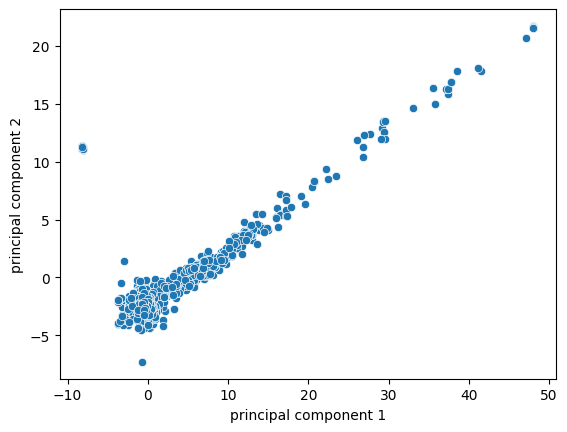

In [11]:
sns.scatterplot(principal['principal component 1'], principal['principal component 2'])

Теперь обучаем PCA+KMeans

Применим elbow method:

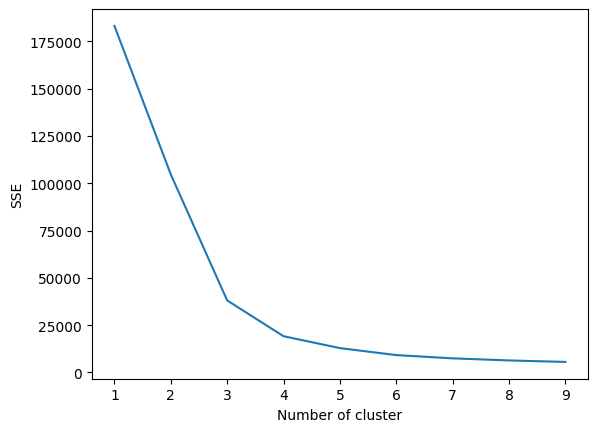

In [24]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

data = principal

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [38]:
kmeans = KMeans(n_clusters=5).fit(principal)
l = kmeans.labels_

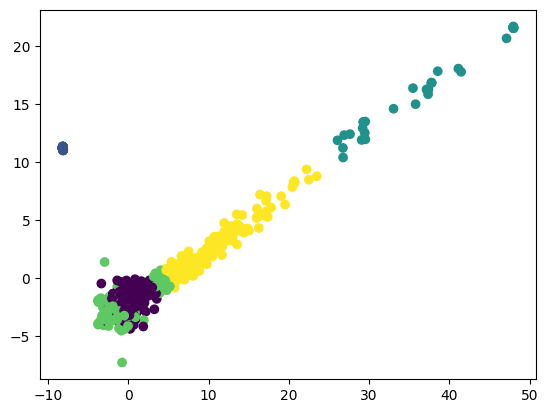

In [39]:
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=l,
           )

In [41]:
from sklearn import metrics
metrics.silhouette_score(principal,l)
# https://stephenallwright.com/good-clustering-metrics/

0.7937167254569303

Теперь DBSCAN

0.8228274645053499

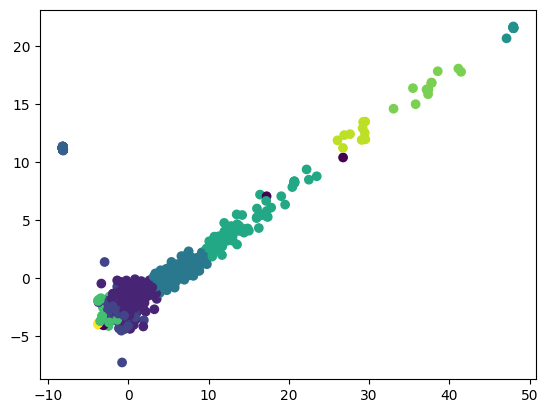

In [47]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=2).fit(principal)
clustering.labels_
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=clustering.labels_,
           )
metrics.silhouette_score(principal,clustering.labels_)

Теперь GM, 9 определил опытным путем

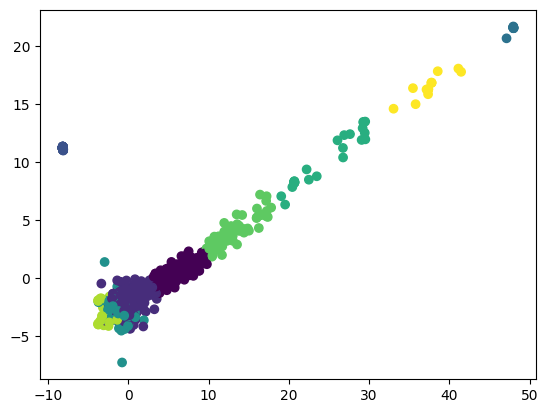

In [66]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=9, random_state=0).fit(principal)
gm.predict(principal)
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=gm.predict(principal),
           )

In [67]:
metrics.silhouette_score(principal,gm.predict(principal))

0.8254936310797131

Что за кластеры:

In [348]:
df['clust'] = l

In [100]:
df.loc[df['clust']==0]['О себе']

22      ---
31      ---
33      ---
34      ---
46      ---
       ... 
2711    ---
2716    ---
2717    ---
2723    ---
2724    ---
Name: О себе, Length: 356, dtype: object

In [102]:
df.loc[df['clust']==1]['О себе']

0       Уверенный пользователь ПК, Ms Word, Ms Excel, ...
1       Энергична, активна, в поиске новых возможносте...
2       опыт прямых продаж, ведение коммерческих перег...
3       Коммуникабелен\nУмение работать с возражениями...
4       Дисциплина - умение выполнять поставленные зад...
                              ...                        
2714    Опыт управления более 15-и лет. Развитые управ...
2715    Аналитика продаж ,поиск клиентов,связь с произ...
2719    Многозадачность, стрессоустойчивость, инициати...
2720    Уверенный пользователь ПК: MS Office (Word, Ex...
2722                                                    .
Name: О себе, Length: 2156, dtype: object

In [103]:
df.loc[df['clust']==2]['О себе']

58      Общий стаж работы более 20 лет. Легко обучаюсь...
128     Легко и быстро обучаюсь, целеустремленная, вни...
298     Добрый день. Немного обо мне: Успешное провиде...
336     Аналитический склад ума, высокая концентрация,...
376     Пунктуальная, исполнительная, мобильная.\nУмею...
513     • Умею и люблю учиться;\n• Пунктуальна и дисци...
593     Работал с людьми обладаю управлять командой зн...
661     Люблю ответственность и ответственных людей, п...
759     Умею работать в режиме многозадачности, пункту...
891     Ответственная, целеустремленная, коммуникабель...
1020    Готова сразу приступить к работе.\n\nExcel- ув...
1140    Люблю думать, создавать, видеть в своей работе...
1298    Имею опыт работы в коллективе, организована, о...
1442    Здравствуйте, меня зовут Ксения.\nИз качеств о...
1493    Уравновешенный, целеустремленный, коммуникабел...
1530    Я люблю интересную работу с возможностями разв...
1556    Очень люблю автомобили, много читаю, в т.ч. те...
1595    Легко 

In [104]:
df.loc[df['clust']==3]['О себе']

29      Разбираюсь в новых системах и проектах, люблю ...
32      Имею большой опыт в продажах. Работая в любом ...
101     легко обучаема,целеустремленная,клиентоорентир...
109     - люблю много и результативно работать\n- ценю...
113     Ответственная, активная, быстро обучаюсь и усв...
                              ...                        
2701    Пользователь MS Office (Word, Excel, Internet)...
2706    ответственная, коммуникабельная, работаю в усл...
2708    Сильный бэкграунд, опыт работы в различных сфе...
2718    Коммуникабельный,инновационный.\nОбладаю спосо...
2721    Моя потребность в постоянном улучшении себя на...
Name: О себе, Length: 176, dtype: object

In [101]:
for x in np.unique(df['clust']):
    print(x + 1, ':', df.loc[df['clust']==x]['О себе'].shape[0])

1 : 356
2 : 2156
3 : 37
4 : 176
